In [2]:
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import json
import autograd.numpy as np
import seaborn as sns

sns.set_context('poster')

from pin import pin

%matplotlib inline

/Users/ericmjl/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/ericmjl/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:583: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [27]:
with open('../experiments/all_graphs/outputs/all-graphs_1000-iters_wbs.pkl', 'rb') as f:
    wb = pkl.load(f)

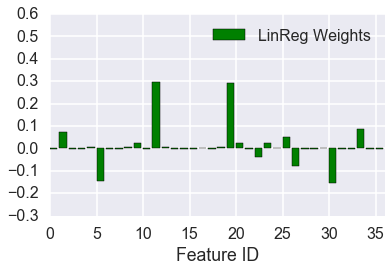

In [28]:
# Visualize importance of each of the features in the linear regression stage

fig = plt.figure(figsize=(6,4))
ylim = (-0.3, 0.6)

layer0 = wb['layer0_GraphConvLayer']['biases'].T
layer1 = wb['layer1_FingerprintLayer']['weights'].T
layer2 = wb['layer2_LinearRegressionLayer']['linweights']

plt.bar(range(len(layer2)), layer2, label='LinReg Weights', color='green')
plt.xlim(0, 36)
plt.legend(loc='best')
plt.ylim(*ylim)
plt.xlabel('Feature ID')
plt.subplots_adjust(bottom=0.2)
plt.savefig('figures/linreg_weights.pdf')

In [29]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler(feature_range=(10,100))
opacities = mms.fit_transform(np.abs(layer2))
for i, op in enumerate(opacities.astype(int)):
    print(i, op)

0 [10]
1 [31]
2 [10]
3 [10]
4 [11]
5 [54]
6 [10]
7 [10]
8 [11]
9 [16]
10 [10]
11 [100]
12 [11]
13 [10]
14 [10]
15 [10]
16 [10]
17 [10]
18 [11]
19 [98]
20 [17]
21 [10]
22 [20]
23 [16]
24 [10]
25 [24]
26 [33]
27 [10]
28 [10]
29 [10]
30 [56]
31 [10]
32 [10]
33 [35]
34 [10]
35 [10]


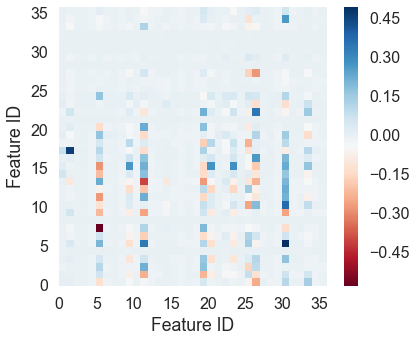

In [30]:
# Layer 0: Convolution Weights
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
plt.pcolor(wb['layer0_GraphConvLayer']['weights'], cmap=plt.cm.RdBu)
plt.colorbar()
ax.set_xlim(0,36)
ax.set_ylim(0,36)
ax.set_xlabel('Feature ID')
ax.set_ylabel('Feature ID')

In [31]:
drug_data = pd.read_csv('../data/hiv_data/hiv-protease-data-expanded.csv', index_col=0)
drug_data['FPV'] = drug_data['FPV'].apply(np.log10)
drug_data.head(3)

,ATV,DRV,FPV,IDV,LPV,NFV,SQV,SeqID,TPV,seqid,sequence,sequence_object,weight
0,NaN,NaN,0.397940,16.3,NaN,38.6,16.1,2996,NaN,2996-0,PQITLWQRPIVTIKIGGQLKEALLDTGADDTVLEDVNLPGRWKPKM...,ID: 2996-0\nName: <unknown name>\nDescription:...,0.50
1,NaN,NaN,0.397940,16.3,NaN,38.6,16.1,2996,NaN,2996-1,PQITLWQRPIVTIKIGGQLKEALLDTGADDTVLEDVNLPGRWKPKM...,ID: 2996-1\nName: <unknown name>\nDescription:...,0.50
2,NaN,NaN,-0.154902,0.8,NaN,0.8,1.1,4387,NaN,4387-0,PQITLWQRPLVTIKVGGQLKEALLDTGADDTVLEDMELPGRWKPKM...,ID: 4387-0\nName: <unknown name>\nDescription:...,0.25


In [32]:
drug_data[(drug_data['FPV'] == drug_data['FPV'].max()) & (drug_data['weight'] == 1)].tail(3)

,ATV,DRV,FPV,IDV,LPV,NFV,SQV,SeqID,TPV,seqid,sequence,sequence_object,weight
6007,104.0,120.0,2.60206,30.0,65.0,54.0,45.0,191476,10.0,191476-0,PQITLWQRPFIPVKVGGQPTEALLDTGADDTIFEGINLPGRWKPKM...,ID: 191476-0\nName: <unknown name>\nDescriptio...,1.0
6168,700.0,200.0,2.60206,177.0,500.0,600.0,86.0,205644,800.0,205644-0,PQITLWQRPIISVRIGGQPVEALLDTGADDTILDNINLPGRWTPKL...,ID: 205644-0\nName: <unknown name>\nDescriptio...,1.0
6518,109.0,239.0,2.60206,21.0,87.0,94.0,63.0,230072,7.4,230072-0,PQITLWQRPVITVRVGGQLTEALLDTGADDTIFEEINLPGKWKPKL...,ID: 230072-0\nName: <unknown name>\nDescriptio...,1.0


In [33]:
# We will use the sequence with the SeqID: 230072-0 as the example for "high" FPV resistance.
# The job that has this SeqID is...

seqid = '230072-0'

with open('../data/batch_summary.json', 'r') as f:
    model_data = json.load(f)

def get_project_code_by_title(model_data, title):
    """
    Returns the project which has a title that matches.
    """
    for p in model_data['projects']:
        if p['title'] == title:
            return p
            break
    
code = get_project_code_by_title(model_data, seqid)['code']
p = pin.ProteinInteractionNetwork('../data/batch_models/{0}/model_01.pdb'.format(code))

In [34]:
# Find the node that gives the maximal activation on the convolution, given the weights in the convolutional layer.
activations = dict()
for n, d in p.nodes(data=True):
    activations[n] = np.dot(d['features'], wb['layer2_LinearRegressionLayer']['linweights'])[0]
    
activations

{'A10VAL': array([-0.53198185]),
 'A11ILE': array([-3.88627819]),
 'A12THR': array([-0.49427965]),
 'A13VAL': array([-3.79999389]),
 'A14ARG': array([-0.35943082]),
 'A15VAL': array([-3.81228992]),
 'A16GLY': array([-0.47855725]),
 'A17GLY': array([-0.47794508]),
 'A18GLN': array([-0.50026661]),
 'A19LEU': array([-0.48830488]),
 'A1PRO': array([-0.84818636]),
 'A20THR': array([-0.99317094]),
 'A21GLU': array([-0.52904048]),
 'A22ALA': array([-2.34855718]),
 'A23LEU': array([-1.40680315]),
 'A24LEU': array([-5.11919298]),
 'A25ASP': array([-0.53442456]),
 'A26THR': array([-0.79100526]),
 'A27GLY': array([-0.47887889]),
 'A28ALA': array([-1.04855136]),
 'A29ASP': array([-0.56043727]),
 'A2GLN': array([-0.6879741]),
 'A30ASP': array([-1.03377157]),
 'A31THR': array([-0.91748931]),
 'A32ILE': array([-3.7359737]),
 'A33PHE': array([-5.14388299]),
 'A34GLU': array([-0.28331906]),
 'A35GLU': array([-0.28598398]),
 'A36ILE': array([-2.2330974]),
 'A37ASN': array([-0.4387759]),
 'A38LEU': array

In [35]:
# Some helper functions for the notebook.

def max_key(dictionary):
    vals = [i for i in dictionary.values()]
    max_val = max(vals)
    for k, v in dictionary.items():
        if v == max_val:
            return k

def invert(dictionary):
    from collections import defaultdict
    
    
    inverted = defaultdict(list)
    for k, v in dictionary.items():
        inverted[v].append(k)
    
    return inverted

def get_keys_by_value(dictionary, value):
    """
    More general than get_max_key().
    """
    keys = []
    for k, v in dictionary.items():
        if v == value:
            keys.append(k)
    return keys

In [36]:
layer = layer2
layer_idxd = {i: val for i, val in enumerate(layer)}
layer_values = sorted(layer, reverse=True)
layer_values

maxkey = max_key(layer_idxd)
print(maxkey)
nextmaxkey = get_keys_by_value(layer_idxd, layer_values[1])[0]
print(nextmaxkey)

11
19


In [37]:
top_features = []
for n, a in activations.items():
    top_features.append((n, a[0]))

top_feats_sorted = sorted(top_features, key=lambda x:x[1], reverse=True)
top_feats_sorted

[('B6TRP', 0.29030681496727889),
 ('A6TRP', 0.29030681496727889),
 ('B8ARG', 0.12990422849136801),
 ('B4THR', -0.0046679749445809448),
 ('A4THR', -0.0046679749445809448),
 ('A7GLN', -0.0091015297997234582),
 ('B7GLN', -0.0091015297997234582),
 ('B2GLN', -0.22854544767900153),
 ('A34GLU', -0.283319059541421),
 ('B35GLU', -0.28539953510153049),
 ('B34GLU', -0.2856295676257179),
 ('A35GLU', -0.28598397822334776),
 ('B30ASP', -0.28753064260426131),
 ('A8ARG', -0.32221942015797467),
 ('A14ARG', -0.35943081875493293),
 ('B14ARG', -0.36018517635201514),
 ('A37ASN', -0.4387759042074193),
 ('A57LYS', -0.44584833841803961),
 ('A43LYS', -0.44692380141441101),
 ('B43LYS', -0.44765216980582556),
 ('B45LYS', -0.44787795310612999),
 ('B55LYS', -0.44799468978375212),
 ('A41LYS', -0.44823586819324002),
 ('B41LYS', -0.44901059591912573),
 ('A55LYS', -0.4503540823688974),
 ('A68GLU', -0.45741676476186877),
 ('B68GLU', -0.45872297152273855),
 ('A51GLY', -0.47075938434742548),
 ('A52GLY', -0.47156981745258

In [54]:
top_feats_df = pd.DataFrame(top_feats_sorted)
top_feats_df[1] = -top_feats_df[1]
top_feats_df.sort_values(1, ascending=False, inplace=True)
top_feats_df.head()

,0,1
197,B85ILE,5.291387
196,A85ILE,5.273470
195,B33PHE,5.156709
194,A33PHE,5.143883
193,A24LEU,5.119193


In [55]:
p.neighbors('B85ILE')

['B66ILE',
 'B84VAL',
 'B24LEU',
 'B89VAL',
 'B90MET',
 'B86GLY',
 'B22ALA',
 'B13VAL',
 'B64ILE',
 'B11ILE',
 'B33PHE']

In [57]:
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
top_feats_transformed = ss.fit_transform(top_feats_df[1].reshape(-1, 1))

['B85ILE']


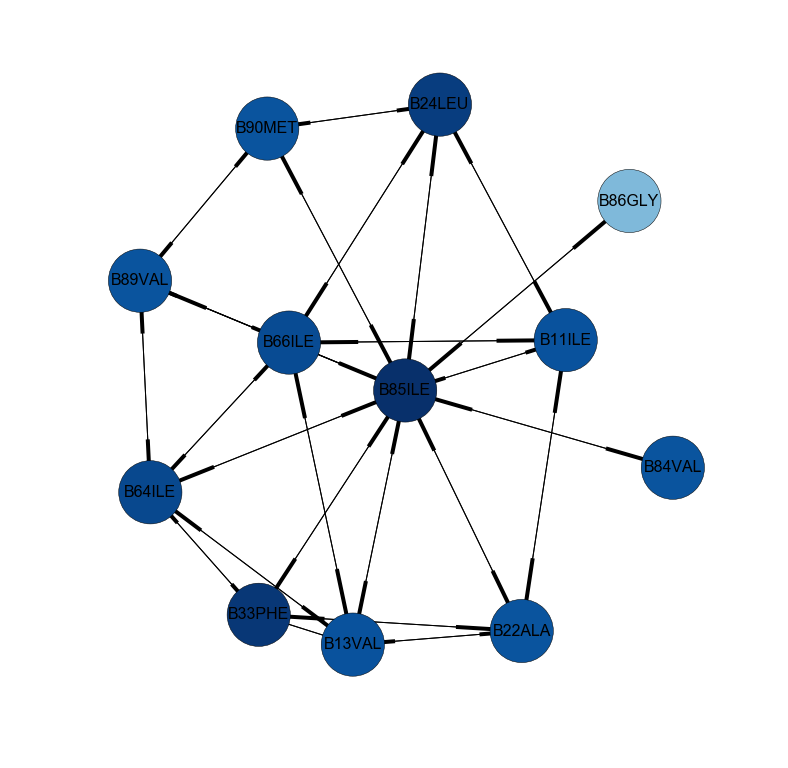

In [59]:
import networkx as nx

nois = top_feats_df.sort_values(1, ascending=False)[0:1][0].values
print(nois)
def get_subgraph_nodes_and_neighbors(p, nois):
    g = p.to_directed()
    nois = nois
    sg_nodes = []
    for n in nois:
        sg_nodes.append(n)
        sg_nodes.extend(p.neighbors(n))

    sg = g.subgraph(sg_nodes)

    return sg

def draw_subgraph_activations(p, nois, cmap):
    """
    Draws the subgraph of nodes 
    """
    sg = get_subgraph_nodes_and_neighbors(p, nois)
    fig = plt.figure(figsize=(10,10))
    pos = nx.spring_layout(sg, scale=3, k=0.4, iterations=100)

    cmap = cmap
    nodemap = dict()
    for r, d in top_feats_df.iterrows():
        nodemap[d[0]] = cmap(top_feats_transformed)[r][0]


    nx.draw(sg, pos, node_size=4000, node_color=[nodemap[n] for n in sg.nodes()])
    nx.draw_networkx_labels(sg, pos, font_size=16)

draw_subgraph_activations(p, nois, cmap=plt.get_cmap('Blues_r'))
plt.savefig('figures/top_activating_features.pdf')

In [52]:
!ls

__pycache__             figures                 visualize_weights.ipynb
baseline.ipynb          predictions.ipynb
custom_funcs.py         script_prototypes.ipynb


In [53]:
resinums = ''
for n, d in get_subgraph_nodes_and_neighbors(p, nois).nodes(data=True):
    resinums = resinums + str(d['resi_num']) + '+'
resinums

'89+86+22+85+11+84+66+33+24+13+64+90+'

In [49]:
p